In [20]:
from data_processing.Datasets import get_maestro_dataset, collate_fn
from torch.utils.data import DataLoader
import torch
from model.transformer import Transformer
from functools import partial
import muspy
import copy

# NOTE: THIS DOWNLOADS SOMETHING, NEEDED TO GENERATE MUSIC WITH MUSPY
muspy.download_musescore_soundfont()


Skip downloading as the MuseScore General soundfont is found.


In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# data hyperparams
SEQ_LEN = 1500
BATCH_SIZE = 32
EVAL_BATCH_SIZE = 10

# model hyperparams
NUM_TOKENS = 388
DIM_MODEL = 512
NUM_HEADS = 2
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DROPOUT_P = 0.1

REPRESENTATION = "event"  # set to either 'event' or 'pitch'


In [23]:
# load device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [24]:
train_data, test_data = get_maestro_dataset(
    "data/maestro", representation=REPRESENTATION
)


Skip downloading as the `.muspy.success` file is found.
Skip extracting as the `.muspy.success` file is found.
Skip conversion as the `.muspy.success` file is found.


In [25]:
# Build dataloaders
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    collate_fn=partial(collate_fn, seq_len=SEQ_LEN, device=device),
    shuffle=False,
)

val_dataloader = DataLoader(
    dataset=test_data,
    batch_size=EVAL_BATCH_SIZE,
    collate_fn=partial(collate_fn, seq_len=SEQ_LEN, device=device),
    shuffle=False,
)


In [26]:
# create model, optim, criterion
model = Transformer(
    num_tokens=NUM_TOKENS,
    dim_model=DIM_MODEL,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dropout_p=DROPOUT_P,
).to(device)


## Prepare Primer

This cell loads a small sample from the validation dataset that is passed into the transformer to be used as a baseline for generating more music.


torch.Size([50, 1])
torch.Size([50, 1])


[<AxesSubplot:xlabel='time (beat)', ylabel='\n\npitch'>]

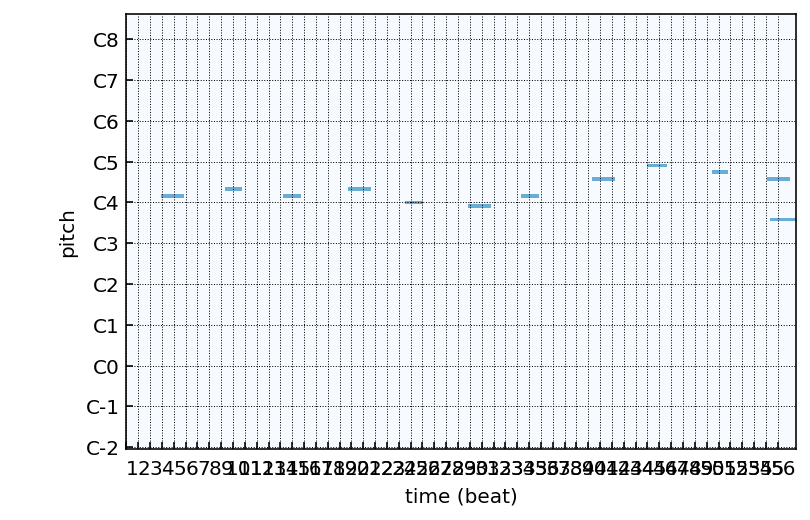

In [27]:
# prepare primer
primer = torch.tensor(test_data.__getitem__(10), dtype=torch.long)

labels = copy.deepcopy(primer)

primer = primer[100:150].to(device)
print(primer.shape)
labels = labels[100:150].to(device)
print(labels.shape)

# display primer pianoroll
primer_arr = primer.to('cpu').clone().detach().numpy()

if REPRESENTATION == "pitch":
    music_primer = muspy.from_pitch_representation(primer_arr)
elif REPRESENTATION == "event":
    music_primer = muspy.from_event_representation(primer_arr)

muspy.show_pianoroll(music_primer)


In [28]:
# load saved model params
model.load_state_dict(torch.load("./results/transformer/model_params/model-event-may-11.pth", map_location=torch.device(device)))
model.to(device)

# set to test
model.eval()

# pass in primer
with torch.no_grad():
    data = model.generate(primer.to(device), device, labels.to(device), target_seq_length=1000)

# decode the returned info
data = data.to('cpu').detach().numpy()

if REPRESENTATION == "pitch":
    music = muspy.from_pitch_representation(data)
elif REPRESENTATION == "event":
    music = muspy.from_event_representation(data)
else:
    print(
        "Please use either event or pitch based representation, depending on what the model was trained on."
    )
    print("If you don't know what either of those are, set REPRESENTATION='event'")

muspy.write_audio("./results/transformer/music/test-pitch-short.wav", music, "wav")


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

## Visualize the music


In [ ]:
muspy.show_pianoroll(music)
